# Introduction

This notebook provides an introduction to  **Variational Autoencoders (VAEs)** step by step, starting from out previous understanding of vanilla autoencoders, and highlight how VAEs differ, both conceptually and mathematically.

### Vanilla Autoencoder Recap

A **vanilla autoencoder** is a neural network with two parts:

1. **Encoder**: maps input $\mathbf{x}$ to a latent representation $\mathbf{z}$
2. **Decoder**: reconstructs the input from $\mathbf{z}$, giving $\hat{\mathbf{x}}$

Loss:

$$
\mathcal{L}(\mathbf{x}, \hat{\mathbf{x}}) = \|\mathbf{x} - \hat{\mathbf{x}}\|^2
$$

Goal: minimize reconstruction error — i.e., make $\hat{\mathbf{x}} \approx \mathbf{x}$

### Why Variational Autoencoders?

Vanilla autoencoders learn **point estimates** in latent space. But:

* The latent space may be discontinuous or sparse.
* We can’t **generate** new data effectively by sampling random latent vectors — they might not map to meaningful outputs.

VAE solves this by **modeling the latent space as a distribution**.

### VAE Key Ideas

Instead of encoding $\mathbf{x} \to \mathbf{z}$, a VAE encodes:

$$
\mathbf{x} \to q_\phi(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\boldsymbol{\mu}(\mathbf{x}), \boldsymbol{\sigma}^2(\mathbf{x}))
$$

* The encoder outputs **parameters** of a Gaussian: $\boldsymbol{\mu}, \boldsymbol{\sigma}$
* The decoder samples from this distribution and reconstructs $\mathbf{x}$

---

### VAE Loss Function (ELBO)

The VAE minimizes:

$$
\mathcal{L}_{\text{VAE}} = \underbrace{\mathbb{E}_{q_\phi(\mathbf{z}|\mathbf{x})} \left[ \log p_\theta(\mathbf{x}|\mathbf{z}) \right]}_{\text{(1) Reconstruction Loss}} - \underbrace{D_{\text{KL}} \left[ q_\phi(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z}) \right]}_{\text{(2) Regularization}}
$$

1. **Reconstruction term**: how well the decoder reconstructs the input
2. **KL divergence**: penalizes the encoder for deviating too much from a prior (usually $\mathcal{N}(0, I)$)

---

### Reparameterization Trick

Sampling from $\mathcal{N}(\mu, \sigma^2)$ is **non-differentiable**. To backpropagate, we use:

$$
\mathbf{z} = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

This allows gradients to flow through $\mu, \sigma$, enabling end-to-end training.

---

### Comparison: Vanilla vs VAE

| Aspect                    | Vanilla Autoencoder                | Variational Autoencoder (VAE)              |
| ------------------------- | ---------------------------------- | ------------------------------------------ |
| Latent space              | Fixed point $\mathbf{z}$           | Distribution over $\mathbf{z}$             |
| Encoder output            | Vector                             | Mean and variance                          |
| Loss function             | Reconstruction error               | Reconstruction + KL divergence             |
| Sampling capability       | Poor (no regularized latent space) | Good (continuous, structured latent space) |
| Application to generation | Weak                               | Strong (used in generative modeling)       |

---

### Properties of VAEs

* They build a smooth, regularized latent space
* We can sample **new** data by drawing $\mathbf{z} \sim \mathcal{N}(0, I)$ and decoding
* Can interpolate between points in latent space (e.g., morphing images)

# Variational Autoencoder (VAE) on MNIST

Let's describe the dimensions of each relevant tensor at each stage. We'll assume a **batch size of 128** and a **latent dimension of 2**.

### Input

$$
x ∈ ℝ^{128 × 784}
$$

* Each image is flattened: $28 \times 28 = 784$
* A batch contains 128 images

### Encoder

```python
h = F.relu(self.fc1(x))             # h ∈ ℝ^{128 × 400}
mu = self.fc_mu(h)                  # mu ∈ ℝ^{128 × 2}
logvar = self.fc_logvar(h)          # logvar ∈ ℝ^{128 × 2}
```

* Output of encoder is two vectors per input: $\mu(\mathbf{x})$, $\log \sigma^2(\mathbf{x})$
* These define the mean and log-variance of the 2D latent Gaussian

### Reparameterization

```python
std = torch.exp(0.5 * logvar)       # std ∈ ℝ^{128 × 2}
eps = torch.randn_like(std)         # eps ∈ ℝ^{128 × 2}
z = mu + eps * std                  # z ∈ ℝ^{128 × 2}
```

* This samples a latent vector $\mathbf{z} \sim \mathcal{N}(\mu, \sigma^2)$
* One vector $\mathbf{z} \in \mathbb{R}^2$ per input image

---

### Decoder

```python
h = F.relu(self.fc1(z))             # h ∈ ℝ^{128 × 400}
x_hat = torch.sigmoid(self.fc2(h))  # x_hat ∈ ℝ^{128 × 784}
```

* The decoder maps each $\mathbf{z} \in \mathbb{R}^2$ back to a reconstruction $\hat{\mathbf{x}} \in \mathbb{R}^{784}$

---

### Loss

```python
recon = BCE(x_hat, x)               # scalar
kl = -0.5 * torch.sum(...)          # scalar
loss = recon + kl                   # scalar
```

* Total loss is a scalar computed per batch (often divided by batch size or number of elements)

---

### Summary Table

| Tensor        | Shape (for batch size = 128, latent dim = 2) | Description                |
| ------------- | -------------------------------------------- | -------------------------- |
| `x`           | $128 \times 784$                             | Flattened input images     |
| `h` (encoder) | $128 \times 400$                             | Hidden layer of encoder    |
| `mu`          | $128 \times 2$                               | Mean vector for each input |
| `logvar`      | $128 \times 2$                               | Log-variance vector        |
| `std`         | $128 \times 2$                               | Standard deviation         |
| `eps`         | $128 \times 2$                               | Standard normal noise      |
| `z`           | $128 \times 2$                               | Sampled latent vector      |
| `h` (decoder) | $128 \times 400$                             | Hidden layer of decoder    |
| `x_hat`       | $128 \times 784$                             | Reconstructed images       |

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.21MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 121kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:04<00:00, 383kB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.06MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch 1, Loss: 191.0643
Epoch 2, Loss: 168.6048
Epoch 3, Loss: 164.2192
Epoch 4, Loss: 161.6161
Epoch 5, Loss: 159.7500


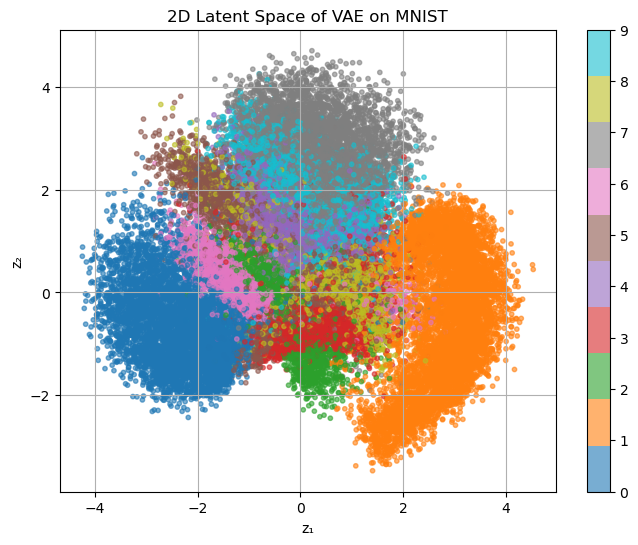

In [1]:
# Variational Autoencoder (VAE) on MNIST
# ======================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Define Encoder, Decoder, and VAE
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=400, output_dim=784):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar, z

# VAE loss
def vae_loss(x, x_hat, mu, logvar):
    recon = F.binary_cross_entropy(x_hat, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl

# Load data
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(5):  # Fewer epochs for demonstration
    total_loss = 0
    for x, _ in train_loader:
        x = x.view(x.size(0), -1).to(device)
        x_hat, mu, logvar, _ = vae(x)

        loss = vae_loss(x, x_hat, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

# Visualization: 2D Latent Space
import numpy as np

vae.eval()
latents = []
labels = []
with torch.no_grad():
    for x, y in train_loader:
        x = x.view(x.size(0), -1).to(device)
        _, _, _, z = vae(x)
        latents.append(z.cpu())
        labels.append(y)

z_all = torch.cat(latents)
y_all = torch.cat(labels)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap="tab10", alpha=0.6, s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title("2D Latent Space of VAE on MNIST")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.show()


# Learned Gaussians

In this visualization of the 2D latent space of a VAE trained on MNIST, the data points form **dense, blob-like clusters**, which visually resemble **ellipsoids or balls**. 

What the Plot Shows:

* Each point represents a latent vector $\mathbf{z} = (z_1, z_2)$ sampled for a specific image from the MNIST dataset.
* Points are color-coded by digit label (0–9).
* The encoder maps each image to a **distribution $\mathcal{N}(\mu(x), \sigma^2(x))$**, from which $\mathbf{z}$ is sampled.

Interpretation of the “Ball” Shapes:

* The **blobby, ellipsoidal clusters** suggest that the encoder has learned **smooth, localized regions** in latent space for each digit class.
* There’s **overlap** between classes — expected, because the KL divergence forces all encoded distributions to stay close to the prior $\mathcal{N}(0, I)$.
* This structure ensures that the latent space is **continuous and interpolatable**, allowing for generation and class blending.

> Each "ball" is a cloud of $\mathbf{z}$ samples for a digit class, shaped by the learned mean and variance of the encoder. Their layout shows that the VAE learned a **structured, dense, and semantically meaningful latent space** while staying close to the prior distribution.

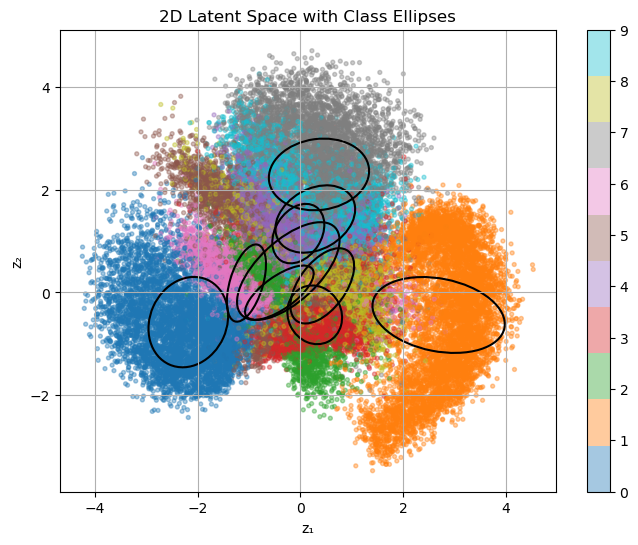

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import torch

# Convert to NumPy for easier manipulation
z_np = z_all.numpy()
y_np = y_all.numpy()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_np[:, 0], z_np[:, 1], c=y_np, cmap="tab10", alpha=0.4, s=8)

# Add one confidence ellipse per class
for digit in range(10):
    points = z_np[y_np == digit]
    if len(points) < 2:
        continue  # skip if not enough points

    # Compute mean and covariance of the latent vectors for this digit
    mean = np.mean(points, axis=0)
    cov = np.cov(points, rowvar=False)
    vals, vecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*vecs[:, 1][::-1]))
    width, height = 2 * np.sqrt(vals)  # 1 standard deviation

    ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
                  edgecolor='black', facecolor='none', linewidth=1.5)
    plt.gca().add_patch(ell)

plt.title("2D Latent Space with Class Ellipses")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.colorbar(scatter, ticks=range(10))
plt.grid(True)
plt.show()


### **Generated Samples from Latent Space**

> **What it shows:** New digit-like images decoded from randomly sampled latent vectors $\mathbf{z} \sim \mathcal{N}(0, I)$.

> **Purpose:** Demonstrates the **generative power** of the VAE. The model has learned a meaningful mapping from a Gaussian latent space to realistic data samples.

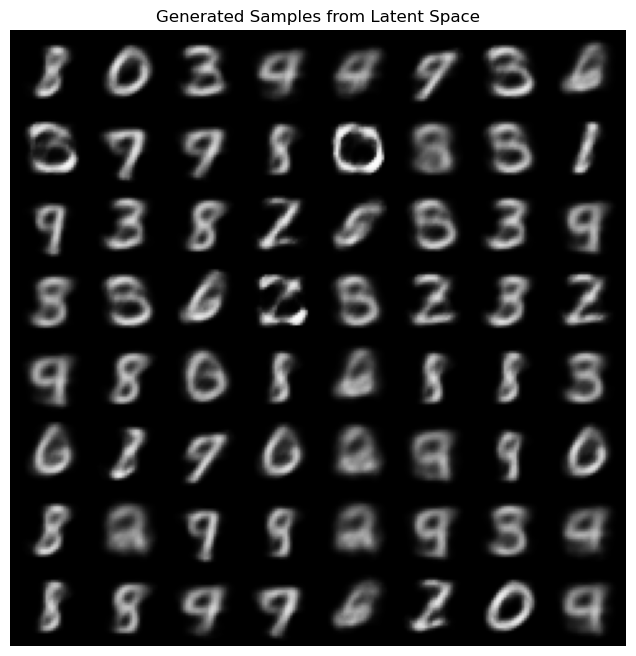

In [2]:
# Generate new samples
vae.eval()
with torch.no_grad():
    z = torch.randn(64, 2).to(device)  # 64 samples from N(0, I)
    samples = vae.decoder(z).cpu().view(-1, 1, 28, 28)

# Plot the samples in an 8×8 grid
grid = make_grid(samples, nrow=8, padding=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("Generated Samples from Latent Space")
plt.show()


### **Input vs Reconstruction**

> **What it shows:** A side-by-side comparison of original input images and their reconstructions produced by the VAE.

> **Purpose:** Evaluates how well the VAE **compresses and reconstructs** input data, reflecting the encoder–decoder's fidelity.

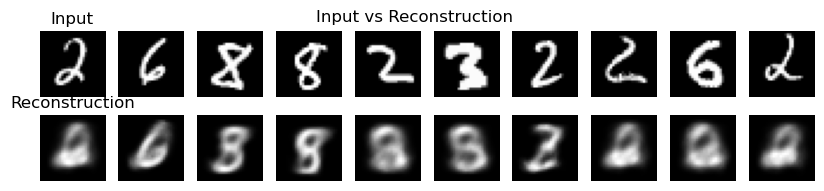

In [3]:
# Get one batch from train_loader
x_batch, _ = next(iter(train_loader))
x_batch = x_batch.view(-1, 784).to(device)
vae.eval()
with torch.no_grad():
    x_hat, _, _, _ = vae(x_batch)

# Show 10 input images and their reconstructions
n = 10
x_batch = x_batch.cpu().view(-1, 1, 28, 28)
x_hat = x_hat.cpu().view(-1, 1, 28, 28)

fig, axes = plt.subplots(2, n, figsize=(n, 2))
for i in range(n):
    axes[0, i].imshow(x_batch[i][0], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(x_hat[i][0], cmap='gray')
    axes[1, i].axis('off')
axes[0, 0].set_title("Input")
axes[1, 0].set_title("Reconstruction")
plt.suptitle("Input vs Reconstruction")
plt.show()


### **2D Latent Space Grid (Decoder Manifold)**

> **What it shows:** A smooth grid of images generated by decoding points sampled from a 2D grid in latent space.

> **Purpose:** Visualizes the **structure and continuity** of the latent space: nearby points yield similar outputs, showing that the decoder generalizes smoothly across $\mathbf{z}$.


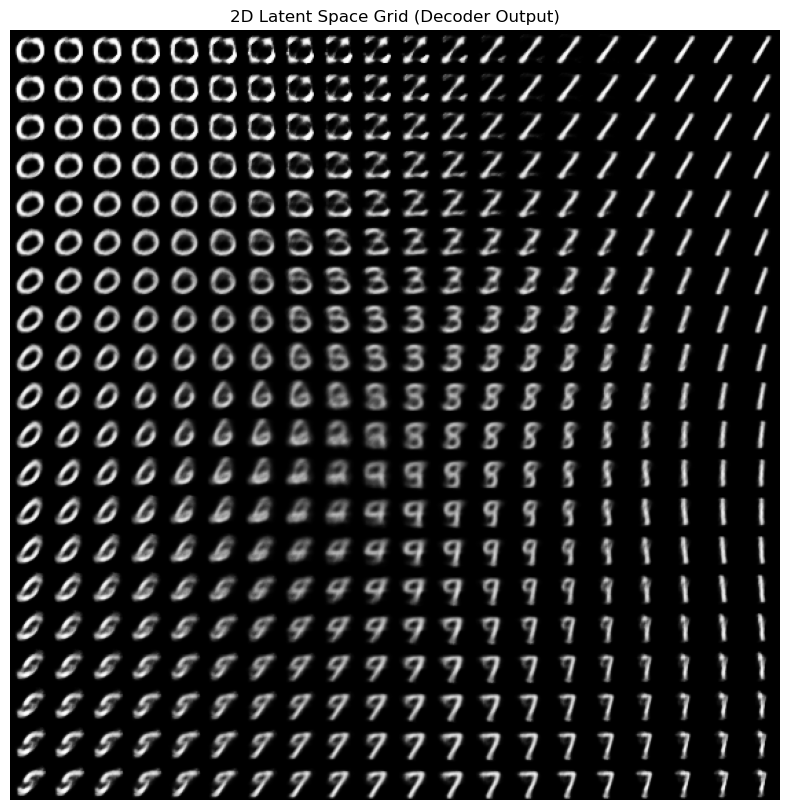

In [4]:
# Only works if latent_dim = 2
n = 20
grid_x = torch.linspace(-3, 3, n)
grid_y = torch.linspace(-3, 3, n)
vae.eval()
samples = []

with torch.no_grad():
    for y in grid_y:
        row = []
        for x in grid_x:
            z = torch.tensor([[x.item(), y.item()]]).to(device)
            sample = vae.decoder(z).view(1, 28, 28).cpu()
            row.append(sample)
        samples.append(torch.cat(row, dim=2))
    full_image = torch.cat(samples, dim=1)

plt.figure(figsize=(10, 10))
plt.imshow(full_image.squeeze(), cmap='gray')
plt.axis('off')
plt.title("2D Latent Space Grid (Decoder Output)")
plt.show()


# Appendix - Multimensional Gaussians

The code below produces subplots showing samples from four different **2D Gaussian distributions**, each with distinct covariance structures:

* **Gaussian 1**: Circular — no correlation between dimensions
* **Gaussian 2**: Elliptical, aligned with axes — different variances
* **Gaussian 3**: Elliptical, positively correlated — diagonally stretched
* **Gaussian 4**: Elliptical, negatively correlated — stretched in the opposite diagonal

This illustrates how 2D Gaussians can take on different shapes depending on their covariance matrix.


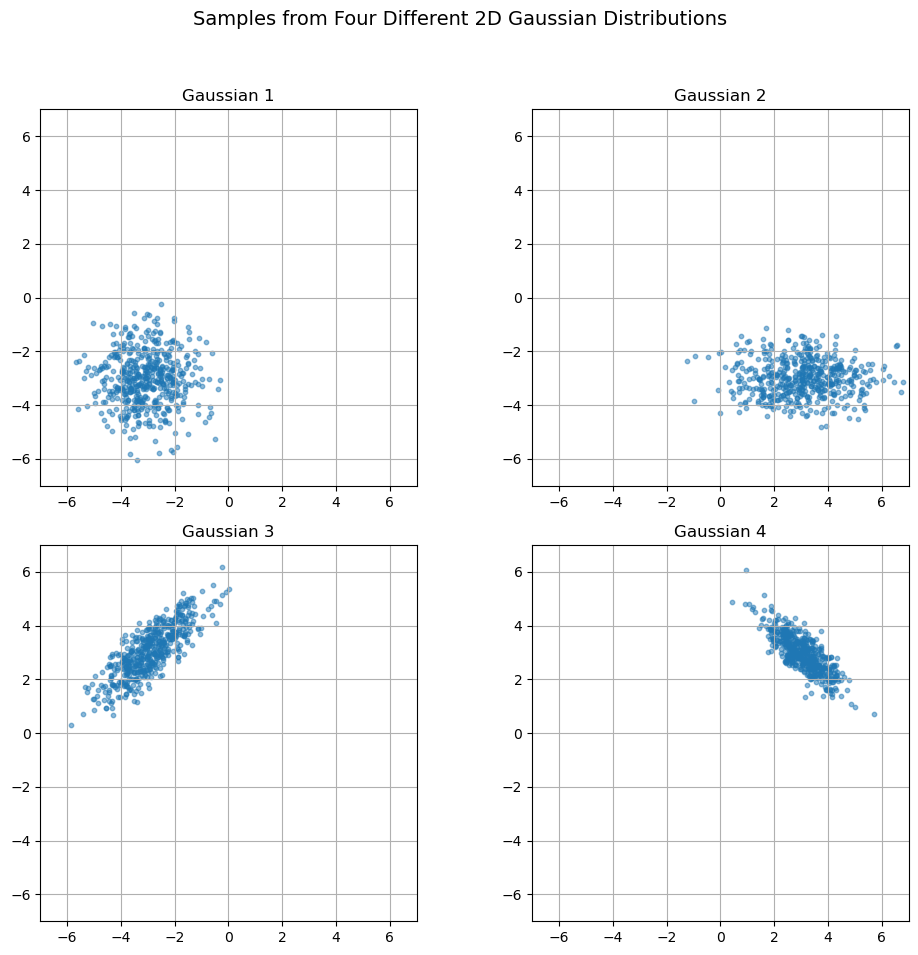

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# Define four 2D Gaussian distributions
means = [(-3, -3), (3, -3), (-3, 3), (3, 3)]
covs = [
    [[1, 0], [0, 1]],        # circular
    [[2, 0], [0, 0.5]],      # elliptical, aligned
    [[1, 0.8], [0.8, 1]],    # elliptical, rotated
    [[0.5, -0.4], [-0.4, 0.5]]  # narrow, rotated
]

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

# Sample and plot
for i in range(4):
    samples = np.random.multivariate_normal(mean=means[i], cov=covs[i], size=500)
    ax = axes[i]
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10)
    ax.set_title(f"Gaussian {i+1}")
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    ax.set_aspect('equal')
    ax.grid(True)

plt.suptitle("Samples from Four Different 2D Gaussian Distributions", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
